### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as sm
import datetime
from pandas_datareader import data
import yfinance as yfin
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statsmodels.api as sm
cwd = os.getcwd()

### Specify the Investment Universe

In [2]:
financial_ticker = "JPM"
technology_ticker = "NVDA"
communication_ticker = "GOOG"
consumer_ticker = "WMT"
industrial_ticker = "MMM"
healthcare_ticker = "JNJ"
energy_ticker = "CVX"
all_tickers = [financial_ticker, technology_ticker, communication_ticker, consumer_ticker, industrial_ticker, healthcare_ticker, energy_ticker]

### Store and Extract data from Yahoo Finance

In [3]:
#### we use adjusted close as our price series
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = pd.DataFrame()
for ticker in all_tickers:
    yfin.pdr_override()
    df_tmp = data.get_data_yahoo(ticker, start, end)
    df = pd.concat([df, df_tmp['Adj Close']], axis = 1)
df.columns = all_tickers
df.to_csv(cwd + '\\price_data')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Read Data

In [4]:
prices = pd.read_csv(cwd + '\\price_data', index_col = 0)
prices.index = pd.to_datetime(prices.index)
prices.head()

JPM       NVDA       GOOG        WMT         MMM  \
2018-01-02  89.602837  49.310482  53.250000  29.440807  147.142426   
2018-01-03  89.694168  52.555782  54.124001  29.697626  147.136215   
2018-01-04  90.979073  52.832836  54.320000  29.724491  149.059464   
2018-01-05  90.395020  53.280544  55.111500  29.900677  150.220901   
2018-01-08  90.528519  54.913094  55.347000  30.342638  149.733856   

                   JNJ        CVX  
2018-01-02  117.502716  97.522385  
2018-01-03  118.625137  98.233253  
2018-01-04  118.616730  97.927521  
2018-01-05  119.595673  97.766998  
2018-01-08  119.747589  98.248550

### Data Cleaning

In [5]:
# check data type
type(prices['JPM'][0])

numpy.float64

In [6]:
# for each column, if there are NaNs, return the column name and the number of NaNs
[(col, prices[col].isnull().sum()) for col in prices.columns if prices[col].isnull().any()]

[]

No amendments required

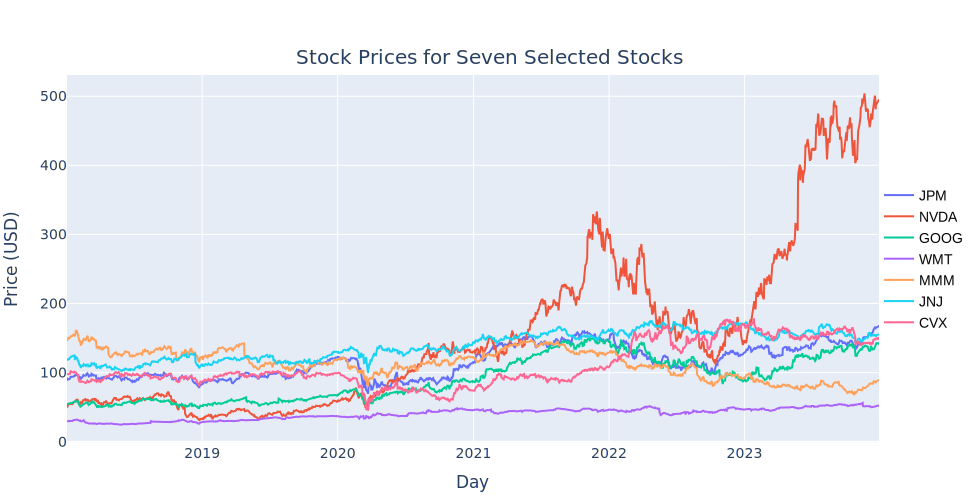

In [7]:
fig = go.Figure()

for ticker in prices:

    fig.add_trace(
            go.Scatter(x = prices.index,
                       y = prices[ticker],
                       mode='lines',
                       name = ticker)
    )


fig.update_layout(
        title = dict(
            text=r'Stock Prices for Seven Selected Stocks',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Day',
        yaxis_title = r'Price (USD)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

### Compute Simple Return

In [8]:
returns = prices.pct_change().dropna()

### Train-test/Out-of-sample Split

In [9]:
returns_train = returns.loc[returns.index.year <= 2020]
returns_test = returns.loc[returns.index.year > 2020]

***
## Leverage

In [10]:
r_f = 0.02 # risk-free rate
goog = returns_train['GOOG']
goog

2018-01-03    0.016413
2018-01-04    0.003621
2018-01-05    0.014571
2018-01-08    0.004273
2018-01-09   -0.000614
                ...   
2020-12-24    0.003735
2020-12-28    0.021416
2020-12-29   -0.009780
2020-12-30   -0.010917
2020-12-31    0.007105
Name: GOOG, Length: 755, dtype: float64

### Kelly Criterion

In [11]:
mu = goog.mean() * 252
std = goog.std() * np.sqrt(252)
kelly = (mu - r_f)/(std**2)
print('GOOG mean: ', mu)
print('GOOG std: ', std)
print('GOOG Kelly: ', kelly)

GOOG mean:  0.21357591057635683
GOOG std:  0.30774127060007317
GOOG Kelly:  2.0439949841081364


### Bootstrapping

In [12]:
%%time
np.random.seed(2024)
N = 10000
results = {}
leverage_ratios = np.arange(0.5, 6, 0.5)
for leverage in leverage_ratios:
    results[leverage] = []
    for _ in range(N):
        net_ret_sample = goog.sample(goog.shape[0], replace = True) * leverage - r_f * (leverage - 1) / 252
        one_plus = net_ret_sample + 1
        cum_ret = one_plus.cumprod()
        results[leverage].append((np.exp((1/cum_ret.shape[0])*np.log(cum_ret.iloc[-1])))**252-1)

CPU times: total: 32.2 s
Wall time: 58.1 s


In [13]:
q95 = [np.quantile(x, .95) for x in results.values()]
q75 = [np.quantile(x, .75) for x in results.values()]
q50 = [np.quantile(x, .5) for x in results.values()]
q25 = [np.quantile(x, .25) for x in results.values()]
q5 = [np.quantile(x, .05) for x in results.values()]

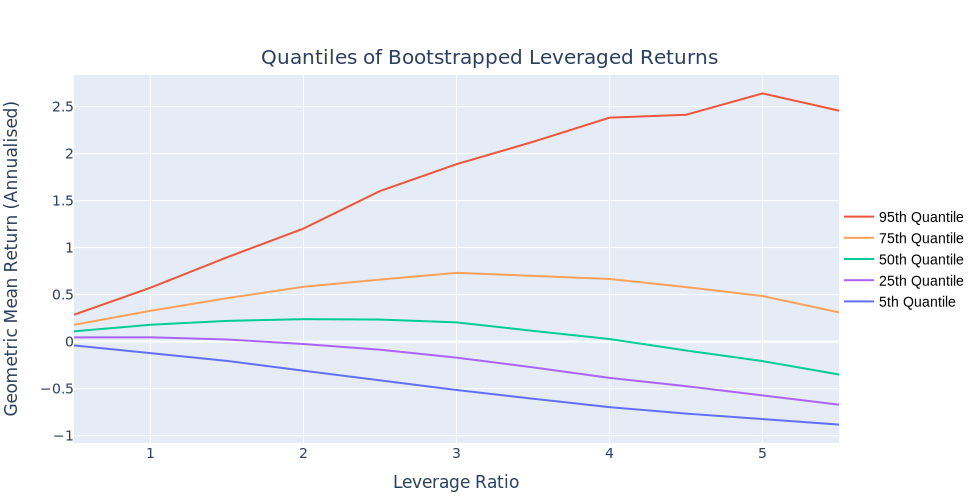

In [14]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = leverage_ratios,
                   y = q95,
                   mode='lines',
                   line_color = '#EF553B',
                   name = '95th Quantile')
)

fig.add_trace(
        go.Scatter(x = leverage_ratios,
                   y = q75,
                   mode='lines',
                   line_color = '#FFA15A',
                   name = '75th Quantile')
)

fig.add_trace(
        go.Scatter(x = leverage_ratios,
                   y = q50,
                   mode='lines',
                   line_color = '#00CC96',
                   name = '50th Quantile')
)

fig.add_trace(
        go.Scatter(x = leverage_ratios,
                   y = q25,
                   mode='lines',
                   line_color = '#AB63FA',
                   name = '25th Quantile')
)

fig.add_trace(
        go.Scatter(x = leverage_ratios,
                   y = q5,
                   mode='lines',
                   line_color = '#636EFA',
                   name = '5th Quantile')
)


fig.update_layout(
        title = dict(
            text=r'Quantiles of Bootstrapped Leveraged Returns',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Leverage Ratio',
        yaxis_title = r'Geometric Mean Return (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

In [15]:
hist_data = [results[1], results[2]]

group_labels = ['Leverage Ratio 1', 'Leverage Ratio 2']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.1)

fig.update_layout(
        title = dict(
            text=r'Histogram of Bootstrapped Leveraged Returns',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Geometric Mean Return (Annualised)',
        yaxis_title = r'Sampling Frequency',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

***
## Portfolio Theory

### Monte Carlo Efficient Frontier

In [16]:
%%time
# generating random long-only portfolios
np.random.seed(2024)
R = returns_train.mean(axis = 0).values
omega = returns_train.cov().values
n = 20000
number_of_assets = len(R)
portfolio_weights = []
volatilities = []
expected_returns = []

for i in range(n):
    # generate random weights that sums up to 1
    random_numbers = np.random.uniform(low=-1000, high=10000, size = number_of_assets)
    weights = random_numbers/np.sum(random_numbers)
    portfolio_weights.append(weights)
    expected_returns.append(np.dot(weights.T,R*252))
    volatilities.append(np.sqrt(np.dot(np.dot(weights.T,omega*252),weights)))
    
sharpe_ratio = np.array([x/y for x,y in zip(expected_returns, volatilities)])

# finding the tangency portfolio
tan_idx = sharpe_ratio.argmax()
tan_return = expected_returns[tan_idx]
tan_vol = volatilities[tan_idx]
tan_weights = portfolio_weights[tan_idx]
print('Expected Return: %f'%tan_return)
print('Volatility: %f'%tan_vol)
pd.DataFrame(tan_weights, index = all_tickers, columns = ['Weightings']).T

Expected Return: 0.308079
Volatility: 0.302339
CPU times: total: 625 ms
Wall time: 691 ms


JPM      NVDA      GOOG       WMT      MMM      JNJ       CVX
Weightings  0.079086  0.423928  0.139866  0.428955 -0.04111 -0.00842 -0.022305

In [17]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = volatilities,
                   y = expected_returns,
                   mode = 'markers',
                   marker = dict(
                        size = 10,
                        color = [x/y for x, y in zip(expected_returns, volatilities)],
                        colorscale = 'tempo'),
                   name = 'Simulated Portfolios')
)

fig.add_trace(
        go.Scatter(x = [tan_vol],
                   y = [tan_return],
                   mode = 'markers',
                   marker_symbol = 'x',
                   marker = dict(
                        size = 18,
                        color = 'red'),
                   name = 'Tangency Portfolio')
)

fig.add_trace(
        go.Scatter(x = np.sqrt(np.diag(omega)*252),
                   y = R*252,
                   mode = 'markers',
                   marker_symbol = 'diamond',
                   marker = dict(
                        size = 13,
                        color = 'orange'),
                   name = 'Single Stocks')
)


fig.update_layout(
        title = dict(
            text=r'Scatter Plot of Random Long-only Portfolios',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Volatilities (Annualised)',
        yaxis_title = r'Expected Returns (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

### Efficient Frontier by Lagrangian Multiplier - Short Sell Allowed

In [18]:
%%time
weights = []
expected_returns = []
vols = []
R = returns_train.mean(axis = 0).values * 252
omega = returns_train.cov().values * 252

for target in range(0, 80):
    target_return = target/100
    equations = []
    for i in range(len(R)):
        equation = list(omega[i]).copy()
        equation.append(-R[i])
        equation.append(-1)
        equations.append(np.array(equation))
    equations.append(np.array(list(R).copy() + [0, 0]))
    equations.append(np.array([1]*len(R) + [0, 0]))
    equals = [0]*len(R) + [target_return, 1]

    x = np.linalg.solve(np.array(equations), np.array(equals))
    
    weights.append(x)
    expected_returns.append(np.dot(x[0:len(R)], R))
    vols.append(np.sqrt(np.dot(np.dot(x[0:len(R)].T,omega),x[0:len(R)])))

CPU times: total: 15.6 ms
Wall time: 16.1 ms


In [19]:
# volatilities at 0, 0.1, 0.2, 0.3, 0.4, 0.5 expected return
pd.DataFrame(np.array(vols)[[0, 10, 20, 30, 40, 50]]).T

0         1         2         3         4         5
0  0.207491  0.195413  0.211806  0.251156  0.304695  0.366253

In [20]:
# weights at 0, 0.1, 0.2, 0.3, 0.4, 0.5 expected return
pd.DataFrame(np.array(weights)[[0, 10, 20, 30, 40, 50]][:, 0:len(R)], columns = all_tickers)

JPM      NVDA      GOOG       WMT       MMM       JNJ       CVX
0 -0.159359 -0.232295  0.178885  0.368713  0.357650  0.346602  0.139803
1 -0.010437 -0.103981  0.200306  0.420329  0.133161  0.353705  0.006917
2  0.138484  0.024332  0.221727  0.471945 -0.091327  0.360807 -0.125969
3  0.287405  0.152646  0.243148  0.523562 -0.315816  0.367910 -0.258855
4  0.436326  0.280960  0.264569  0.575178 -0.540305  0.375013 -0.391741
5  0.585248  0.409273  0.285990  0.626794 -0.764794  0.382116 -0.524627

### Efficient Frontier by Lagrangian Multiplier - Long only

In [21]:
%%time
weights_lo = []
expected_returns_lo = []
vols_lo = []

for target in range(0, int(max(R)*100) + 1):
    target_return = target/100
    weight_final = weights[target][:len(R)]
    if all(w >= 0 for w in weight_final):
        weights_lo.append(x)
        expected_returns_lo.append(np.dot(weight_final, R))
        vols_lo.append(np.sqrt(np.dot(np.dot(weight_final.T,omega),weight_final)))
    else:
        while (not all(w >= 0 for w in weight_final)):
            init_x = np.where(weight_final > 0, 1, 0)
            init_v = np.where(weight_final > 0, 0, 1)
            equations = []
            for i in range(len(R)):
                equation = list(omega[i][init_x == 1]).copy()
                equation.append(-R[i])
                equation.append(-1)
                for j in range(len(R)):
                    if init_v[j] == 1:
                        if i == j:
                            equation.append(-1)
                        else:
                            equation.append(0)
                    else:
                        pass
                equations.append(np.array(equation))
            equations.append(np.array(list(R[init_x == 1]).copy() + [0, 0] + [0]*len(R[init_v == 1])))
            equations.append(np.array([1]*len(R[init_x == 1]) + [0, 0] + [0]*len(R[init_v == 1])))
            equals = [0]*len(R) + [target_return, 1]

            x = np.linalg.solve(np.array(equations), np.array(equals))

            weight_final = []
            cnt = 0
            for x_tmp in init_x:
                if x_tmp == 1:
                    weight_final.append(x[cnt])
                    cnt += 1
                else:
                    weight_final.append(0)
            lambda_final = []
            for i in range(2):
                lambda_final.append(x[cnt])
                cnt += 1
            v_final = []
            for v_tmp in init_v:
                if v_tmp == 1:
                    v_final.append(x[cnt])
                    cnt += 1
                else:
                    v_final.append(0)

            x = np.array(weight_final + lambda_final + v_final)
            
            weight_final = np.array(weight_final)

       
        weights_lo.append(x)
        expected_returns_lo.append(np.dot(x[0:len(R)], R))
        vols_lo.append(np.sqrt(np.dot(np.dot(x[0:len(R)].T,omega),x[0:len(R)])))

CPU times: total: 31.2 ms
Wall time: 21.1 ms


In [22]:
# volatilities at 0, 0.1, 0.2, 0.3, 0.4, 0.5 expected return
pd.DataFrame(np.array(vols_lo)[[0, 10, 20, 30, 40]]).T

0         1         2         3         4
0  0.265279  0.202026  0.221029  0.302734  0.426241

In [23]:
# weights at 0, 0.1, 0.2, 0.3, 0.4, 0.5 expected return
pd.DataFrame(np.array(weights_lo)[[0, 10, 20, 30, 40]][:, 0:len(R)], columns = all_tickers)

JPM      NVDA      GOOG       WMT       MMM       JNJ       CVX
0  0.000000  0.000000  0.000000  0.000000  0.701464  0.153108  0.145429
1  0.000000  0.000000  0.020665  0.352615  0.207503  0.391470  0.027746
2  0.002838  0.113562  0.194340  0.508914  0.000000  0.180347  0.000000
3  0.000000  0.444590  0.056731  0.498679  0.000000  0.000000  0.000000
4  0.000000  0.817782  0.000000  0.182218  0.000000  0.000000  0.000000

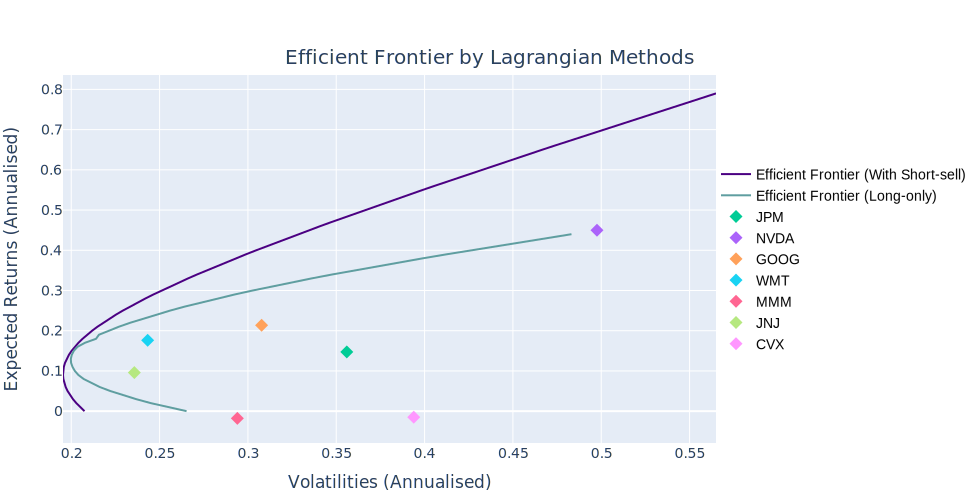

In [24]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = vols,
                   y = expected_returns,
                   mode='lines',
                   line_color = 'indigo', 
                   name = 'Efficient Frontier (With Short-sell)')
)

fig.add_trace(
        go.Scatter(x = vols_lo,
                   y = expected_returns_lo,
                   mode='lines',
                   line_color = 'cadetblue', 
                   name = 'Efficient Frontier (Long-only)')
)
for idx, ticker in enumerate(all_tickers):
    fig.add_trace(
        go.Scatter(x = [np.sqrt(np.diag(omega))[idx]],
                   y = [R[idx]],
                   mode = 'markers',
                   marker_symbol = 'diamond',
                   marker = dict(
                        size = 10),
                   name = ticker)
    )

fig.update_layout(
        title = dict(
            text=r'Efficient Frontier by Lagrangian Methods',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Volatilities (Annualised)',
        yaxis_title = r'Expected Returns (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

### Tangency Portfolio

In [25]:
def tan_port_ss(mu, Sigma, r_f):
    x = np.dot(np.linalg.inv(Sigma), mu - r_f)
    return x / sum(x)

def tan_port_lo(mu, Sigma, r_f):
    weight_final = tan_port_ss(mu, Sigma, r_f)
    while (not all(w >= 0 for w in weight_final)):
        # guessing zeros for original negative weightings
        init_x = np.where(weight_final > 0, 1, 0)
        init_u = np.where(weight_final < 0, 1, 0)
        # adjust the covariance matrix
        kkt_cov = []
        for idx, w in enumerate(weight_final):
            if w >= 0:
                kkt_cov.append(Sigma[idx, :])
            else:
                kkt_ar = list(np.zeros(len(weight_final) - 1))
                kkt_ar.insert(idx, -1)
                kkt_cov.append(np.array(kkt_ar))
        kkt_cov = np.array(kkt_cov)
        weight_final = tan_port_ss(mu, kkt_cov, r_f)
        u = weight_final * init_u
        x = weight_final * init_x
        weight_final = x / sum(x)
        
    weight_final = np.where(weight_final == -0, 0, weight_final)
    
    return weight_final

In [26]:
%%time
R = returns_train.mean(axis = 0).values * 252
omega = returns_train.cov().values * 252
r_f = 0.02

tp_ss = tan_port_ss(R, omega, r_f)
tp_lo = tan_port_lo(R, omega, r_f)

tp_ss_ret = np.dot(tp_ss.reshape(1, len(tp_ss)), R.reshape(len(R), 1)).flatten()[0]
tp_ss_vol = np.sqrt(np.dot(np.dot(tp_ss.reshape(1, len(tp_ss)), omega), tp_ss.reshape(len(tp_ss), 1)).flatten()[0])

tp_lo_ret = np.dot(tp_lo.reshape(1, len(tp_lo)), R.reshape(len(R), 1)).flatten()[0]
tp_lo_vol = np.sqrt(np.dot(np.dot(tp_lo.reshape(1, len(tp_lo)), omega), tp_lo.reshape(len(tp_lo), 1)).flatten()[0])

cal_ss_80vol = 0.02 + (tp_ss_ret - 0.02) / (tp_ss_vol) * 0.8
cal_lo_80vol = 0.02 + (tp_lo_ret - 0.02) / (tp_lo_vol) * 0.8


weights = []
expected_returns = []
vols = []
R = returns_train.mean(axis = 0).values * 252
omega = returns_train.cov().values * 252

for target in range(0, 110):
    target_return = target/100
    equations = []
    for i in range(len(R)):
        equation = list(omega[i]).copy()
        equation.append(-R[i])
        equation.append(-1)
        equations.append(np.array(equation))
    equations.append(np.array(list(R).copy() + [0, 0]))
    equations.append(np.array([1]*len(R) + [0, 0]))
    equals = [0]*len(R) + [target_return, 1]

    x = np.linalg.solve(np.array(equations), np.array(equals))
    
    weights.append(x)
    expected_returns.append(np.dot(x[0:len(R)], R))
    vols.append(np.sqrt(np.dot(np.dot(x[0:len(R)].T,omega),x[0:len(R)])))

CPU times: total: 31.2 ms
Wall time: 22.6 ms


In [27]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = vols,
                   y = expected_returns,
                   mode='lines',
                   line_color = 'indigo', 
                   name = 'Efficient Frontier')
)


fig.add_trace(
    go.Scatter(x = [0, 0.8],
               y = [0.02, cal_ss_80vol],
               mode = 'lines',
               name = 'Capital Allocation Line')
)


fig.add_trace(
    go.Scatter(x = [tp_ss_vol],
               y = [tp_ss_ret],
               mode = 'markers',
               marker_symbol = 'x',
               marker = dict(
                    size = 15,
                    color = 'red'),
               name = 'Tangency Portfolio')
)


fig.update_layout(
        title = dict(
            text=r'Tangency Portfolio and Capital Allocation Line - Short Selling Allowed',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Volatilities (Annualised)',
        yaxis_title = r'Expected Returns (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

### Bootstrapping Allocation

In [28]:
N = 1000

In [29]:
def sums_to(length, total_sum):
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(total_sum + 1):
            for permutation in sums_to(length - 1, total_sum - value):
                yield (value,) + permutation

#### 2 Asset Case

In [30]:
%%time
A = list(sums_to(2,10))
two_asset = returns_train[['GOOG', 'WMT']]
sharpe = {}
for allocation in A:
    sharpe[allocation] = []
    for _ in range(N):
        two_asset_sample = two_asset.sample(two_asset.shape[0], replace = True)
        port_sample = np.array([two_asset_sample.iloc[:,idx].values * w / 10 for idx, w in enumerate(allocation)]).sum(axis = 0)
        sharpe[allocation].append((np.mean(port_sample)/np.std(port_sample))*np.sqrt(252))

CPU times: total: 2.84 s
Wall time: 3.95 s


In [31]:
q95 = [np.quantile(x, .95) for x in sharpe.values()]
q75 = [np.quantile(x, .75) for x in sharpe.values()]
q50 = [np.quantile(x, .5) for x in sharpe.values()]
q25 = [np.quantile(x, .25) for x in sharpe.values()]
q5 = [np.quantile(x, .05) for x in sharpe.values()]

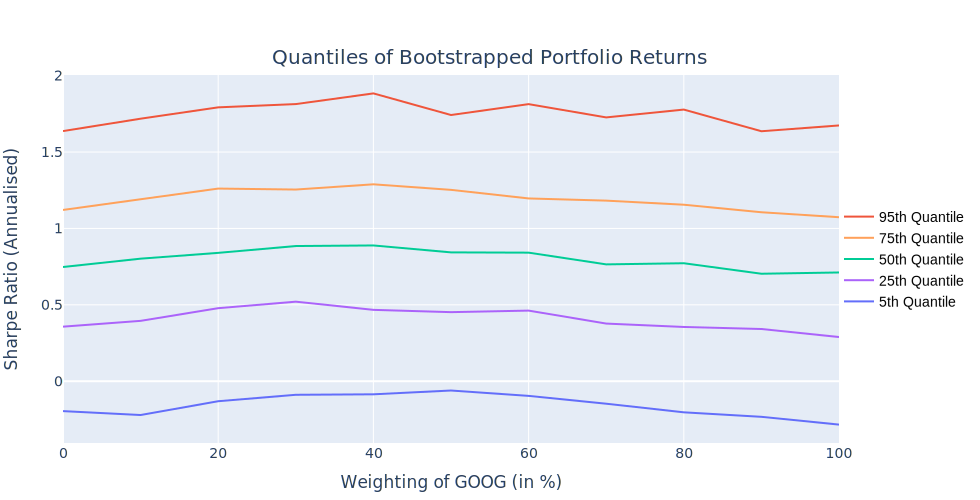

In [32]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = [a[0]*10 for a in A],
                   y = q95,
                   mode='lines',
                   line_color = '#EF553B',
                   name = '95th Quantile')
)

fig.add_trace(
        go.Scatter(x = [a[0]*10 for a in A],
                   y = q75,
                   mode='lines',
                   line_color = '#FFA15A',
                   name = '75th Quantile')
)

fig.add_trace(
        go.Scatter(x = [a[0]*10 for a in A],
                   y = q50,
                   mode='lines',
                   line_color = '#00CC96',
                   name = '50th Quantile')
)

fig.add_trace(
        go.Scatter(x = [a[0]*10 for a in A],
                   y = q25,
                   mode='lines',
                   line_color = '#AB63FA',
                   name = '25th Quantile')
)

fig.add_trace(
        go.Scatter(x = [a[0]*10 for a in A],
                   y = q5,
                   mode='lines',
                   line_color = '#636EFA',
                   name = '5th Quantile')
)


fig.update_layout(
        title = dict(
            text=r'Quantiles of Bootstrapped Portfolio Returns',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Weighting of GOOG (in %)',
        yaxis_title = r'Sharpe Ratio (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

#### 3 Asset Case

In [33]:
%%time
A = list(sums_to(3,10))
three_asset = returns_train[['GOOG', 'WMT', 'NVDA']]
sharpe = {}
for allocation in A:
    sharpe[allocation] = []
    for _ in range(N):
        three_asset_sample = three_asset.sample(two_asset.shape[0], replace = True)
        port_sample = np.array([three_asset_sample.iloc[:,idx].values * w / 10 for idx, w in enumerate(allocation)]).sum(axis = 0)
        sharpe[allocation].append((np.mean(port_sample)/np.std(port_sample))*np.sqrt(252))

CPU times: total: 19.2 s
Wall time: 29.7 s


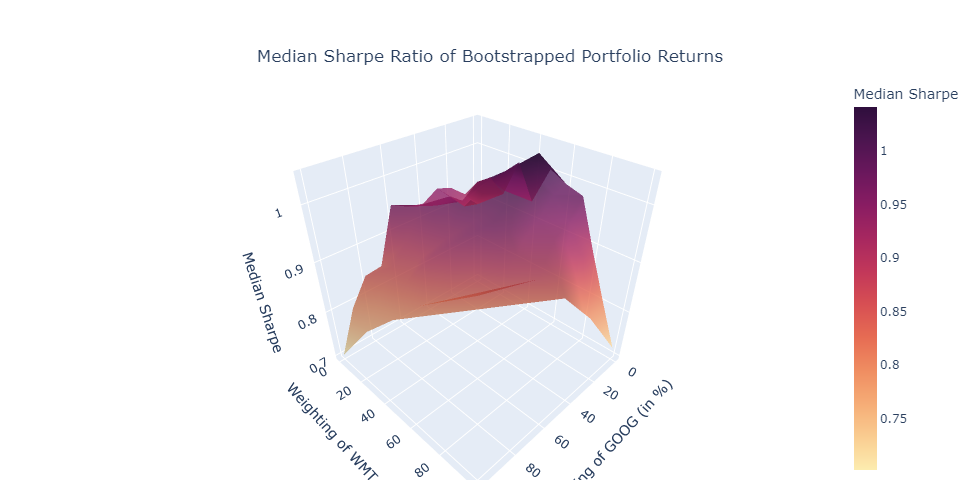

In [34]:
x, y = [a[0]*10 for a in A], [a[1]*10 for a in A]
z = [np.quantile(x, .5) for x in sharpe.values()]


fig = go.Figure()

fig.add_trace(
            go.Mesh3d(x=x, y=y, z=z, opacity=0.8, intensity=z, colorscale='matter', coloraxis='coloraxis1')
        )

fig.update_layout(
        title = dict(
            text = r'Median Sharpe Ratio of Bootstrapped Portfolio Returns',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=12),
        scene=dict(
            xaxis_title='Weighting of GOOG (in %)',
            yaxis_title='Weighting of WMT (in %)',
            zaxis_title='Median Sharpe',
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500,
        coloraxis=dict(colorscale='matter', colorbar_x=0.9, colorbar_thickness=23, colorbar_title = 'Median Sharpe'),
    )

fig.show(renderer="png")
#fig.show()

#### 6 Asset Case

In [35]:
%%time
A_six = list(sums_to(6,100))
len(A_six)

CPU times: total: 1min 7s
Wall time: 1min 37s


96560646

### SIMM

In [36]:
# Extract S&P 500 data
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = pd.DataFrame()
yfin.pdr_override()
df_tmp = data.get_data_yahoo('^SPX', start, end)
df = pd.concat([df, df_tmp['Adj Close']], axis = 1)
df.columns = ['SPX']
df.to_csv(cwd + '\\spx_data')

[*********************100%%**********************]  1 of 1 completed


In [37]:
snp_price = pd.read_csv(cwd + '\\spx_data', index_col = 0)
snp_price.index = pd.to_datetime(snp_price.index)
snp_price.head()

snp_return = snp_price.pct_change().dropna()

snp_return_train = snp_return.loc[snp_return.index.year <= 2020]
snp_return_test = snp_return.loc[snp_return.index.year > 2020]

#### Linear Regression for SIMM

In [38]:
%%time

r_f = 0.02
mu_m = snp_return_train.mean()[0] * 252
sigma_m = snp_return_train.std()[0] * np.sqrt(252)

simm = {}
for col in returns_train.columns:
    y = returns_train[col]
    x = snp_return_train
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    simm[col] = {'alpha': results.params[0]*252,
                 'beta': results.params[1],
                 'tau_squared': results.ess/(snp_return_train.shape[0] - 2)*252,
                 'mu': results.params[0]*252 + results.params[1] * mu_m}

CPU times: total: 0 ns
Wall time: 15.6 ms


In [39]:
pd.DataFrame(simm) # annualised

JPM      NVDA      GOOG       WMT       MMM       JNJ  \
alpha       -0.019824  0.239376  0.067981  0.100914 -0.142808  0.002175   
beta         1.209408  1.523598  1.053893  0.545137  0.904581  0.678841   
tau_squared  0.079812  0.126667  0.060606  0.016216  0.044650  0.025145   
mu           0.147256  0.449862  0.213576  0.176225 -0.017841  0.095956   

                  CVX  
alpha       -0.185288  
beta         1.232844  
tau_squared  0.082935  
mu          -0.014971

In [40]:
cov = []
for i, ticker_i in enumerate(all_tickers):
    for j, ticker_j in enumerate(all_tickers):
        if i == j:
            cov.append(simm[ticker_i]['beta']*simm[ticker_j]['beta']*sigma_m**2 + simm[ticker_i]['tau_squared'])
        else:
            cov.append(simm[ticker_i]['beta']*simm[ticker_j]['beta']*sigma_m**2)
cov = np.array(cov).reshape(len(all_tickers), len(all_tickers))
cov

array([[0.15951811, 0.10041283, 0.06945687, 0.03592732, 0.05961646,
        0.04473905, 0.08125064],
       [0.10041283, 0.25316576, 0.08750094, 0.0452608 , 0.0751041 ,
        0.05636171, 0.10235858],
       [0.06945687, 0.08750094, 0.12113148, 0.03130749, 0.05195049,
        0.03898614, 0.07080278],
       [0.03592732, 0.0452608 , 0.03130749, 0.03240978, 0.02687195,
        0.020166  , 0.0366235 ],
       [0.05961646, 0.0751041 , 0.05195049, 0.02687195, 0.08923986,
        0.03346271, 0.06077168],
       [0.04473905, 0.05636171, 0.03898614, 0.020166  , 0.03346271,
        0.0502574 , 0.04560598],
       [0.08125064, 0.10235858, 0.07080278, 0.0366235 , 0.06077168,
        0.04560598, 0.16576015]])

#### Short Selling Allowed

In [41]:
%%time
A = (sigma_m**2)*sum([(v['beta'] * (v['mu'] - r_f))/v['tau_squared'] for v in simm.values()]) / (1 + (sigma_m**2) * sum([(v['beta']**2)/v['tau_squared'] for v in simm.values()]))
z = [(v['beta']/v['tau_squared']) * ((v['mu'] - r_f)/v['beta'] - A) for v in simm.values()]
simm_ss = np.array([z_i/sum(z) for z_i in z])

CPU times: total: 0 ns
Wall time: 0 ns


#### Long Only

In [42]:
%%time
r = [(v['mu'] - r_f)/v['beta'] for v in simm.values()]
ordered_r = sorted(r, reverse = True)
r_order = [r.index(x) for x in ordered_r]
ordered_tickers = [list(simm.keys())[idx] for idx in r_order]

A_b = []
num_sum = 0
den_sum = 0
for ticker in ordered_tickers:
    num_sum += (simm[ticker]['beta'] * (simm[ticker]['mu'] - r_f)) / simm[ticker]['tau_squared']
    den_sum += (simm[ticker]['beta']**2) / simm[ticker]['tau_squared']
    A_b.append(((sigma_m**2) * num_sum)/(1 + (sigma_m**2)*den_sum))
    
A_b_ast = A_b[np.where(np.array(ordered_r) > np.array(A_b), 1, 0).sum() - 1]

z = []
for idx, ticker in enumerate(simm.keys()):
    if r[idx] > A_b_ast:
        z.append((simm[ticker]['beta']/simm[ticker]['tau_squared'])*((simm[ticker]['mu'] - r_f)/simm[ticker]['beta'] - A_b_ast))
    else:
        z.append(0)
simm_lo = np.array([z_i/sum(z) for z_i in z])

CPU times: total: 0 ns
Wall time: 0 ns


### Robust Estimators

In [43]:
%%time
# these are daily returns and cov

b_1 = 2
b_2 = 1.25
iterations = 10

mu = returns_train.mean(axis = 0).values
Sigma = returns_train.cov().values
k = len(R)

mus = [mu]
Sigmas = [Sigma]

for _ in range(iterations):
    d = np.sqrt(np.dot(np.dot((returns_train - mu).values, np.linalg.inv(Sigma)), (returns_train - mu).values.T).diagonal())
    d_0 = np.sqrt(k) + b_1/np.sqrt(2)
    w = []
    for d_i in d:
        if d_i <= d_0:
            w.append(1)
        else:
            w.append(d_0 * np.exp(-((d_i - d_0)**2)/(2*b_2**2)) / d_i)
    
    # update mu
    mu = np.array([w_i * r_i for w_i, r_i in zip(w, returns_train.values)]).sum(axis = 0) / sum(w)
    
    # update cov
    num = 0
    den = 0
    for i, r_i in enumerate(returns_train.values):
        num += np.dot((r_i - mu).reshape(len(r_i),1), (r_i - mu).reshape(1, len(r_i))) * (w[i]**2)
        den += (w[i]**2)
    Sigma = num/(den - 1)
    
    mus.append(mu)
    Sigmas.append(Sigma)

CPU times: total: 266 ms
Wall time: 138 ms


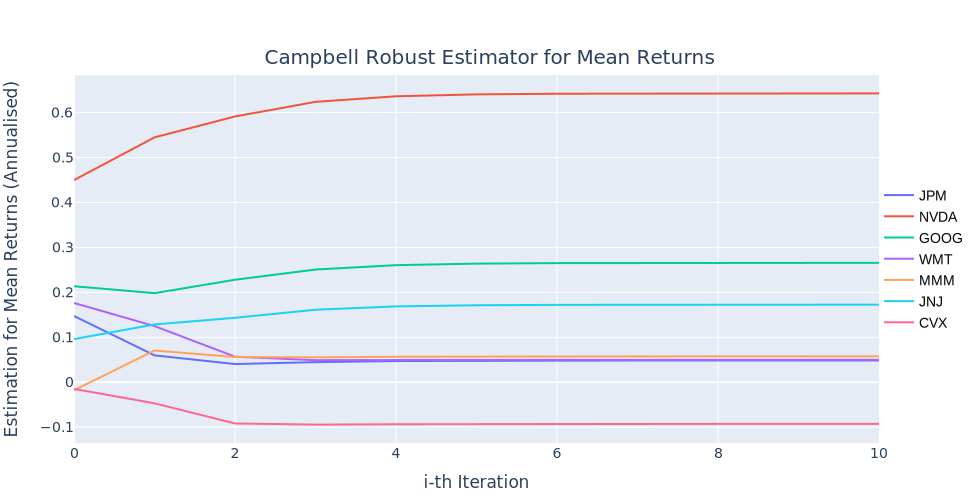

In [44]:
fig = go.Figure()

for idx, estimates in enumerate(np.array(mus).T):

    fig.add_trace(
            go.Scatter(x = np.arange(len(estimates)),
                       y = estimates * 252,
                       mode='lines',
                       name = f'{all_tickers[idx]}')
    )


fig.update_layout(
        title = dict(
            text=r'Campbell Robust Estimator for Mean Returns',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'i-th Iteration',
        yaxis_title = r'Estimation for Mean Returns (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

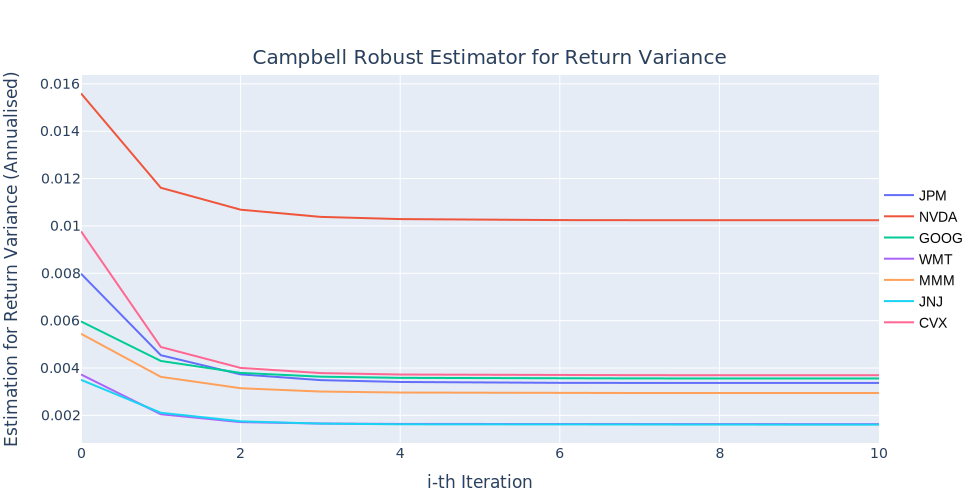

In [45]:
robust_var = [s.diagonal() for s in Sigmas]

fig = go.Figure()

for idx, estimates in enumerate(np.array(robust_var).T):

    fig.add_trace(
            go.Scatter(x = np.arange(len(estimates)),
                       y = estimates * np.sqrt(252),
                       mode='lines',
                       name = f'{all_tickers[idx]}')
    )


fig.update_layout(
        title = dict(
            text=r'Campbell Robust Estimator for Return Variance',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'i-th Iteration',
        yaxis_title = r'Estimation for Return Variance (Annualised)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

In [46]:
mus[0]*252

array([ 0.14725616,  0.44986151,  0.21357591,  0.176225  , -0.01784052,
        0.09595646, -0.01497097])

In [47]:
mus[-1]*252

array([ 0.04836391,  0.64271862,  0.26563189,  0.04985065,  0.05764033,
        0.17254715, -0.09277588])

### Shrinkage Estimators

In [48]:
%%time
# James-Stein Shrinkage Estimator for mu
# daily values are calculated here

mu = returns_train.mean(axis = 0).values
Sigma = returns_train.cov().values

mu_0 = 0.15/252
T = returns_train.shape[0]
k = returns_train.shape[1]

w = min(1, (k - 2) / (T*(np.dot(np.dot((mu - mu_0).reshape(1, len(mu)), np.linalg.inv(Sigma)), (mu - mu_0).reshape(len(mu), 1)).flatten())))

mu_js = (1 - w)*mu + w*mu_0
mu_js*252

CPU times: total: 0 ns
Wall time: 0 ns


array([0.1497715 , 0.17497212, 0.15529453, 0.15218399, 0.13602244,
       0.14549932, 0.13626141])

In [49]:
%%time
# Bayes-Stein Shrinkage Estimator for mu
# daily values are calculated here

mu = returns_train.mean(axis = 0).values
sample_cov = returns_train.cov().values
T = returns_train.shape[0]
k = returns_train.shape[1]

cov_bs = ((T - 1)/(T - k - 2)) * sample_cov
mu_g = (np.dot(np.dot(np.ones(k).reshape(1, k), np.linalg.inv(cov_bs)), mu.reshape(k, 1))) / \
        (np.dot(np.dot(np.ones(k).reshape(1, k), np.linalg.inv(cov_bs)), np.ones(k).reshape(k, 1)))
w = (k + 2) / (k + 2 + T * (np.dot(np.dot((mu - mu_g).reshape(1, k), np.linalg.inv(cov_bs)), (mu - mu_g).reshape(k, 1))))
mu_bs = (1 - w) * mu + w * mu_g
mu_bs = mu_bs.flatten()
mu_bs*252

CPU times: total: 0 ns
Wall time: 0 ns


array([0.11218044, 0.22213127, 0.13627754, 0.12270619, 0.05219302,
       0.09354084, 0.05323567])

### Black Litterman

In [50]:
%%time
# priori
tau = 0.6
m = returns_train.mean(axis = 0).values * 252
m = m.reshape(len(m), 1)
Sigma = returns_train.cov().values * 252**0.5

# posterior
lam = 0.4
v = np.array([0.3, 0.2])
v = v.reshape(len(v), 1)
P = np.array([[0, 1, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, 0]])
Omega = lam * np.dot(P, np.dot(Sigma, P.T))

mu_bl = m + np.dot(tau * np.dot(np.dot(Sigma, P.T), np.linalg.inv(Omega + tau * np.dot(np.dot(P, Sigma), P.T))), v - np.dot(P, m))
mu_bl = mu_bl.flatten()
Sigma_bl = np.linalg.inv((1 / tau) * np.linalg.inv(Sigma) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), P))

CPU times: total: 0 ns
Wall time: 10 ms


In [51]:
mu_bl

array([ 0.1411977 ,  0.35994461,  0.2379354 ,  0.10299504, -0.03791102,
        0.07733449, -0.02050072])

### All Tangency Portfolios

In [52]:
r_f = 0.02
R = returns_train.mean(axis = 0).values
omega = returns_train.cov().values

tan_ports_ss = {}
tan_ports_lo = {}

tan_ports_ss['Markowitz'] = tan_port_ss(R, omega, r_f)
tan_ports_lo['Markowitz'] = tan_port_lo(R, omega, r_f)

tan_ports_ss['Campbell'] = tan_port_ss(mus[-1], Sigmas[-1], r_f)
tan_ports_lo['Campbell'] = tan_port_lo(mus[-1], Sigmas[-1], r_f)

tan_ports_ss['James-Stein'] = tan_port_ss(mu_js, omega, r_f)
tan_ports_lo['James-Stein'] = tan_port_lo(mu_js, omega, r_f)

tan_ports_ss['Bayes-Stein'] = tan_port_ss(mu_bs, cov_bs, r_f)
tan_ports_lo['Bayes-Stein'] = tan_port_lo(mu_bs, cov_bs, r_f)

tan_ports_ss['SIMM'] = simm_ss
tan_ports_lo['SIMM'] = simm_lo

tan_ports_ss['Black Litterman'] = tan_port_ss(mu_bl, Sigma_bl, r_f)
tan_ports_lo['Black Litterman'] = tan_port_lo(mu_bl, Sigma_bl, r_f)

In [53]:
pd.DataFrame(tan_ports_ss, index = all_tickers).T

JPM      NVDA      GOOG       WMT       MMM       JNJ  \
Markowitz       -0.042007 -0.131182  0.195765  0.409387  0.180750  0.352199   
Campbell         0.084328 -0.092337  0.083723  0.439535  0.052629  0.372858   
James-Stein     -0.023784 -0.115481  0.198387  0.415703  0.153281  0.353068   
Bayes-Stein     -0.029339 -0.120267  0.197588  0.413778  0.161654  0.352803   
SIMM            -0.028620  0.537617  0.326394  1.541913 -0.822752 -0.003578   
Black Litterman  0.827925  1.037898  1.033624 -0.241570 -1.175604  0.257982   

                      CVX  
Markowitz        0.035087  
Campbell         0.059263  
James-Stein      0.018827  
Bayes-Stein      0.023783  
SIMM            -0.550973  
Black Litterman -0.740256

In [54]:
pd.DataFrame(tan_ports_lo, index = all_tickers).T

JPM      NVDA      GOOG       WMT       MMM       JNJ  \
Markowitz        0.000000  0.000000  0.085645  0.387126  0.139442  0.383255   
Campbell         0.087692  0.000000  0.009648  0.431373  0.013401  0.395131   
James-Stein      0.000000  0.000000  0.177226  0.367292  0.138412  0.317069   
Bayes-Stein      0.000000  0.000000  0.175720  0.362880  0.145567  0.315832   
SIMM             0.000000  0.254522  0.000000  0.745478  0.000000  0.000000   
Black Litterman  0.000000  0.447176  0.552824  0.000000  0.000000  0.000000   

                      CVX  
Markowitz        0.004531  
Campbell         0.062754  
James-Stein      0.000000  
Bayes-Stein      0.000000  
SIMM             0.000000  
Black Litterman  0.000000

### Training Set Performance

In [55]:
train_ss = {}
train_lo = {}

for model in tan_ports_ss:
    train_ss[model] = np.array([1] + ((returns_train*tan_ports_ss[model]).sum(axis = 1) + 1).cumprod().tolist())
    train_lo[model] = np.array([1] + ((returns_train*tan_ports_lo[model]).sum(axis = 1) + 1).cumprod().tolist())

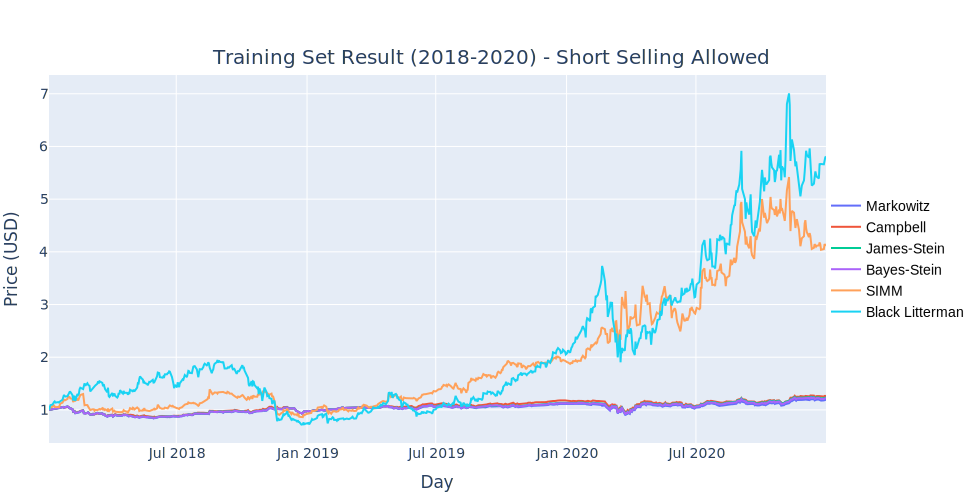

In [56]:
fig = go.Figure()

for model in tan_ports_ss:

    fig.add_trace(
            go.Scatter(x = returns_train.index,
                       y = train_ss[model],
                       mode='lines',
                       name = model)
    )


fig.update_layout(
        title = dict(
            text=r'Training Set Result (2018-2020) - Short Selling Allowed',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Day',
        yaxis_title = r'Price (USD)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

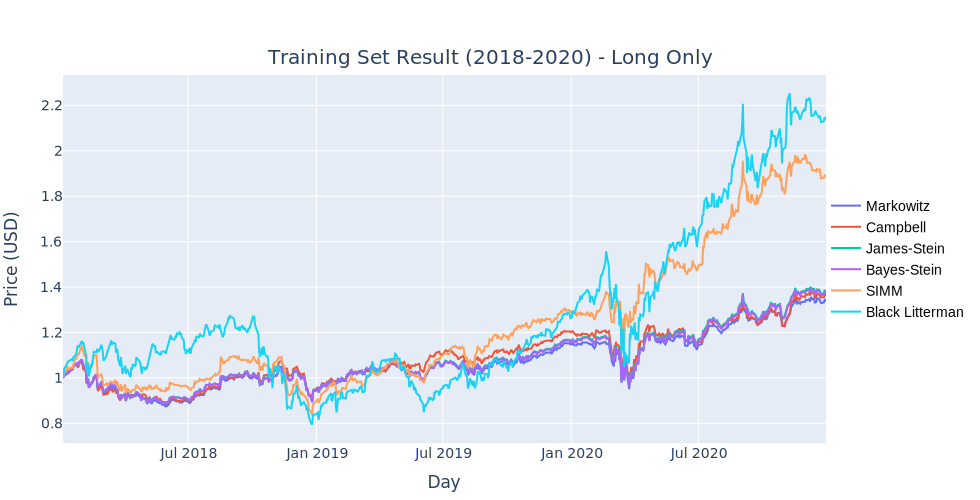

In [57]:
fig = go.Figure()

for model in tan_ports_lo:

    fig.add_trace(
            go.Scatter(x = returns_train.index,
                       y = train_lo[model],
                       mode='lines',
                       name = model)
    )


fig.update_layout(
        title = dict(
            text=r'Training Set Result (2018-2020) - Long Only',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Day',
        yaxis_title = r'Price (USD)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

### Testing Set Performance

In [58]:
bt_ss = {}
bt_lo = {}

for model in tan_ports_ss:
    bt_ss[model] = np.array([1] + ((returns_test*tan_ports_ss[model]).sum(axis = 1) + 1).cumprod().tolist())
    bt_lo[model] = np.array([1] + ((returns_test*tan_ports_lo[model]).sum(axis = 1) + 1).cumprod().tolist())

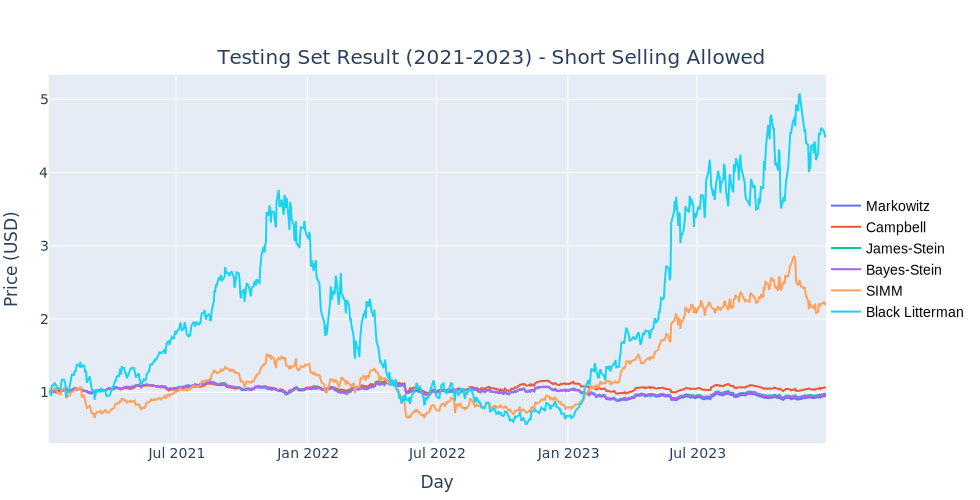

In [59]:
fig = go.Figure()

for model in tan_ports_ss:

    fig.add_trace(
            go.Scatter(x = returns_test.index,
                       y = bt_ss[model],
                       mode='lines',
                       name = model)
    )


fig.update_layout(
        title = dict(
            text=r'Testing Set Result (2021-2023) - Short Selling Allowed',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Day',
        yaxis_title = r'Price (USD)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

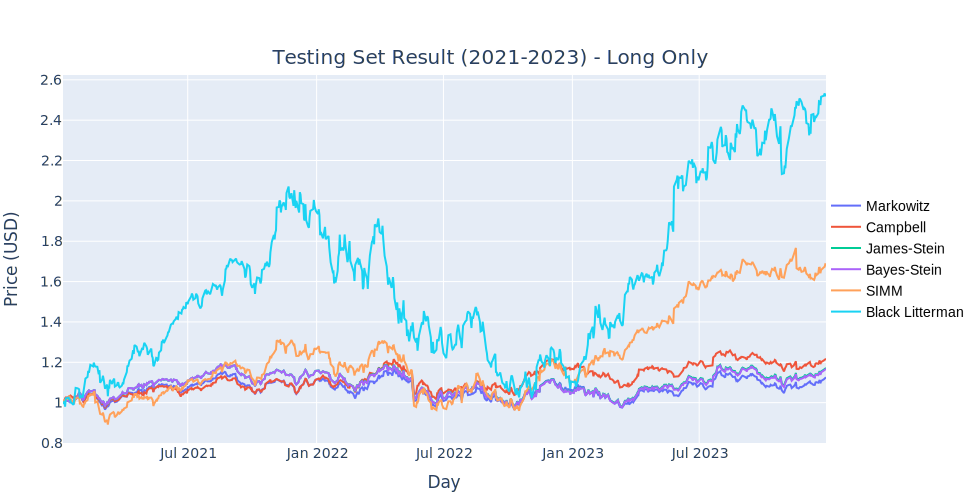

In [60]:
fig = go.Figure()

for model in tan_ports_lo:

    fig.add_trace(
            go.Scatter(x = returns_test.index,
                       y = bt_lo[model],
                       mode='lines',
                       name = model)
    )


fig.update_layout(
        title = dict(
            text=r'Testing Set Result (2021-2023) - Long Only',
            x = 0.5,
            y = 0.9
        ),
        font=dict(size=14),
        xaxis_title = r'Day',
        yaxis_title = r'Price (USD)',
        legend=dict(
        x=1,
        y=0.5,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=14,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)

fig.show(renderer="svg")
#fig.show()

In [61]:
# results for training set
sharpe_ss = {}
sharpe_lo = {}
georet_ss = {}
georet_lo = {}
for model in bt_ss:
    sharpe_ss[model] = (((returns_train*tan_ports_ss[model]).sum(axis = 1)).mean() * 252 - r_f)/((returns_train*tan_ports_ss[model]).sum(axis = 1)).std() / np.sqrt(252)
    sharpe_lo[model] = (((returns_train*tan_ports_lo[model]).sum(axis = 1)).mean() * 252 - r_f)/((returns_train*tan_ports_lo[model]).sum(axis = 1)).std() / np.sqrt(252)
    
    georet_ss[model] = train_ss[model][-1]
    georet_lo[model] = train_lo[model][-1]
    
pd.DataFrame([georet_ss, sharpe_ss, georet_lo, sharpe_lo], index = ['Geometric Return (Short Selling)', 'Sharpe Ratio (Short Selling)', 'Geometric Return (Long Only)', 'Sharpe Ratio (Long Only)']).T

Geometric Return (Short Selling)  \
Markowitz                                1.195851   
Campbell                                 1.272129   
James-Stein                              1.240706   
Bayes-Stein                              1.226892   
SIMM                                     4.116449   
Black Litterman                          5.907119   

                 Sharpe Ratio (Short Selling)  Geometric Return (Long Only)  \
Markowitz                            0.300642                      1.352508   
Campbell                             0.401854                      1.377710   
James-Stein                          0.363691                      1.391838   
Bayes-Stein                          0.344536                      1.386171   
SIMM                                 1.141274                      1.889718   
Black Litterman                      1.191335                      2.143842   

                 Sharpe Ratio (Long Only)  
Markowitz                        0.504008  
Campbell                         0.527525  
James-Stein                      0.550087  
Bayes-Stein                      0.543191  
SIMM                             0.873157  
Black Litterman                  0.835571

In [62]:
# results for testing set
sharpe_ss = {}
sharpe_lo = {}
georet_ss = {}
georet_lo = {}
for model in bt_ss:
    sharpe_ss[model] = (((returns_test*tan_ports_ss[model]).sum(axis = 1)).mean() * 252 - r_f)/((returns_test*tan_ports_ss[model]).sum(axis = 1)).std() / np.sqrt(252)
    sharpe_lo[model] = (((returns_test*tan_ports_lo[model]).sum(axis = 1)).mean() * 252 - r_f)/((returns_test*tan_ports_lo[model]).sum(axis = 1)).std() / np.sqrt(252)
    
    georet_ss[model] = bt_ss[model][-1]
    georet_lo[model] = bt_lo[model][-1]
    
pd.DataFrame([georet_ss, sharpe_ss, georet_lo, sharpe_lo], index = ['Geometric Return (Short Selling)', 'Sharpe Ratio (Short Selling)', 'Geometric Return (Long Only)', 'Sharpe Ratio (Long Only)']).T

Geometric Return (Short Selling)  \
Markowitz                                0.950091   
Campbell                                 1.067830   
James-Stein                              0.981935   
Bayes-Stein                              0.972156   
SIMM                                     2.222029   
Black Litterman                          4.528580   

                 Sharpe Ratio (Short Selling)  Geometric Return (Long Only)  \
Markowitz                           -0.166295                      1.125252   
Campbell                             0.085573                      1.217694   
James-Stein                         -0.097955                      1.171228   
Bayes-Stein                         -0.119076                      1.167135   
SIMM                                 0.747024                      1.684971   
Black Litterman                      0.999540                      2.519626   

                 Sharpe Ratio (Long Only)  
Markowitz                        0.208970  
Campbell                         0.400838  
James-Stein                      0.298512  
Bayes-Stein                      0.290566  
SIMM                             0.819031  
Black Litterman                  0.966533